In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from datetime import datetime
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
train_dir = "/content/drive/MyDrive/train"
test_dir  = "/content/drive/MyDrive/test"


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    class_mode='categorical',
    batch_size=32
)

test_gen = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(48, 48),
    class_mode='categorical',
    batch_size=32
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
!ls "$train_dir"

angry  disgust	fear  happy  neutral  sad  surprise


In [7]:
import os
import pandas as pd

classes = os.listdir(train_dir)
data_count = {}

for c in classes:
    data_count[c] = len(os.listdir(os.path.join(train_dir, c)))

df = pd.DataFrame.from_dict(data_count, orient='index', columns=['count'])
df


,count
surprise,3171
sad,4830
neutral,4965
happy,7215
fear,4097
disgust,436
angry,3995


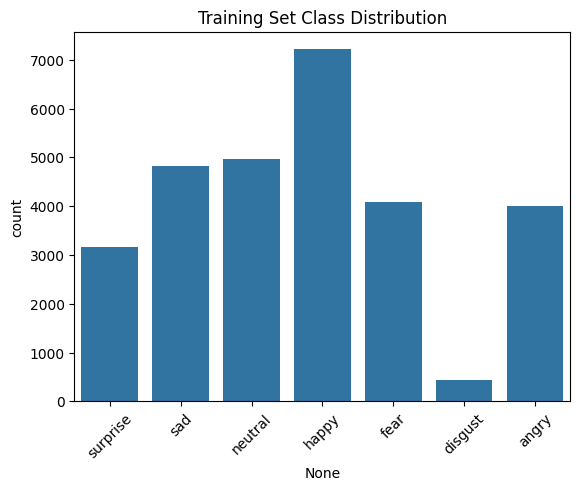

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=df.index, y=df['count'])
plt.title("Training Set Class Distribution")
plt.xticks(rotation=45)
plt.show()


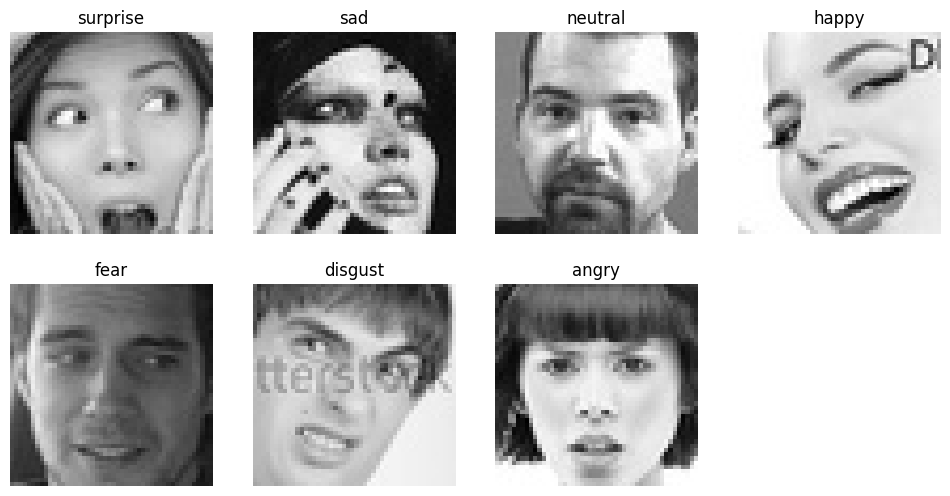

In [9]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(12,6))
i = 1

for c in classes:
    img_path = os.path.join(train_dir, c, os.listdir(os.path.join(train_dir, c))[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2,4,i)
    plt.imshow(img)
    plt.title(c)
    plt.axis('off')
    i += 1

plt.show()


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,        # normalization
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.1   # 10% validation split
)

test_datagen = ImageDataGenerator(rescale=1./255)   # no augmentation


In [11]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    subset='training'
)


Found 25841 images belonging to 7 classes.


In [12]:
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    subset='validation'
)


Found 2868 images belonging to 7 classes.


In [13]:
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)


Found 7178 images belonging to 7 classes.


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn(input_shape=(48,48,1), n_classes=7):
    inputs = tf.keras.Input(shape=input_shape)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D((2,2))(x)
        x = layers.Dropout(0.25)(x)
        return x

    x = conv_block(inputs, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)

    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(n_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

model = build_cnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 1,471,975 (5.62 MB)

 Trainable params: 1,469,799 (5.61 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True)
early = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[checkpoint, early, reduce],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.2156 - loss: 2.0890 

404/404 ━━━━━━━━━━━━━━━━━━━━ 7981s 20s/step - accuracy: 0.2157 - loss: 2.0886 - val_accuracy: 0.3082 - val_loss: 1.7190 - learning_rate: 0.0010
Epoch 2/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.3356 - loss: 1.6974

404/404 ━━━━━━━━━━━━━━━━━━━━ 95s 234ms/step - accuracy: 0.3357 - loss: 1.6972 - val_accuracy: 0.4041 - val_loss: 1.5458 - learning_rate: 0.0010
Epoch 3/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.4307 - loss: 1.4662

404/404 ━━━━━━━━━━━━━━━━━━━━ 93s 230ms/step - accuracy: 0.4307 - loss: 1.4661 - val_accuracy: 0.4271 - val_loss: 1.4646 - learning_rate: 0.0010
Epoch 4/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.4794 - loss: 1.3550

404/404 ━━━━━━━━━━━━━━━━━━━━ 93s 230ms/step - accuracy: 0.4794 - loss: 1.3549 - val_accuracy: 0.5045 - val_loss: 1.2910 - learning_rate: 0.0010
Epoch 5/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5082 - loss: 1.2886

404/404 ━━━━━━━━━━━━━━━━━━━━ 93s 230ms/step - accuracy: 0.5083 - loss: 1.2886 - val_accuracy: 0.5150 - val_loss: 1.2483 - learning_rate: 0.0010
Epoch 6/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5299 - loss: 1.2436

404/404 ━━━━━━━━━━━━━━━━━━━━ 93s 230ms/step - accuracy: 0.5299 - loss: 1.2436 - val_accuracy: 0.5268 - val_loss: 1.2364 - learning_rate: 0.0010
Epoch 7/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 92s 228ms/step - accuracy: 0.5567 - loss: 1.1982 - val_accuracy: 0.5129 - val_loss: 1.2231 - learning_rate: 0.0010
Epoch 8/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5556 - loss: 1.1831

404/404 ━━━━━━━━━━━━━━━━━━━━ 92s 229ms/step - accuracy: 0.5556 - loss: 1.1831 - val_accuracy: 0.5415 - val_loss: 1.1778 - learning_rate: 0.0010
Epoch 9/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.5537 - loss: 1.1659

404/404 ━━━━━━━━━━━━━━━━━━━━ 92s 228ms/step - accuracy: 0.5537 - loss: 1.1658 - val_accuracy: 0.5687 - val_loss: 1.1396 - learning_rate: 0.0010
Epoch 10/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 95s 235ms/step - accuracy: 0.5717 - loss: 1.1355 - val_accuracy: 0.5558 - val_loss: 1.1727 - learning_rate: 0.0010
Epoch 11/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5845 - loss: 1.1077

404/404 ━━━━━━━━━━━━━━━━━━━━ 94s 231ms/step - accuracy: 0.5845 - loss: 1.1078 - val_accuracy: 0.5840 - val_loss: 1.1164 - learning_rate: 0.0010
Epoch 12/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5797 - loss: 1.1151

404/404 ━━━━━━━━━━━━━━━━━━━━ 93s 230ms/step - accuracy: 0.5797 - loss: 1.1151 - val_accuracy: 0.5886 - val_loss: 1.0978 - learning_rate: 0.0010
Epoch 13/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 92s 227ms/step - accuracy: 0.5951 - loss: 1.0880 - val_accuracy: 0.5349 - val_loss: 1.2408 - learning_rate: 0.0010
Epoch 14/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.5983 - loss: 1.0822

404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 225ms/step - accuracy: 0.5983 - loss: 1.0822 - val_accuracy: 0.5952 - val_loss: 1.0621 - learning_rate: 0.0010
Epoch 15/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 226ms/step - accuracy: 0.6043 - loss: 1.0655 - val_accuracy: 0.5805 - val_loss: 1.1180 - learning_rate: 0.0010
Epoch 16/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6057 - loss: 1.0571

404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 226ms/step - accuracy: 0.6057 - loss: 1.0572 - val_accuracy: 0.6199 - val_loss: 1.0163 - learning_rate: 0.0010
Epoch 17/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 92s 227ms/step - accuracy: 0.6017 - loss: 1.0537 - val_accuracy: 0.6050 - val_loss: 1.0569 - learning_rate: 0.0010
Epoch 18/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 225ms/step - accuracy: 0.6118 - loss: 1.0323 - val_accuracy: 0.6070 - val_loss: 1.0416 - learning_rate: 0.0010
Epoch 19/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 226ms/step - accuracy: 0.6165 - loss: 1.0253 - val_accuracy: 0.6109 - val_loss: 1.0218 - learning_rate: 0.0010
Epoch 20/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6289 - loss: 0.9957

404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 226ms/step - accuracy: 0.6289 - loss: 0.9957 - val_accuracy: 0.6217 - val_loss: 1.0155 - learning_rate: 5.0000e-04
Epoch 21/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6378 - loss: 0.9646

404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 226ms/step - accuracy: 0.6378 - loss: 0.9647 - val_accuracy: 0.6391 - val_loss: 0.9712 - learning_rate: 5.0000e-04
Epoch 22/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 92s 228ms/step - accuracy: 0.6410 - loss: 0.9566 - val_accuracy: 0.6168 - val_loss: 1.0277 - learning_rate: 5.0000e-04
Epoch 23/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 93s 230ms/step - accuracy: 0.6423 - loss: 0.9543 - val_accuracy: 0.6259 - val_loss: 1.0081 - learning_rate: 5.0000e-04
Epoch 24/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 225ms/step - accuracy: 0.6470 - loss: 0.9353 - val_accuracy: 0.6349 - val_loss: 0.9859 - learning_rate: 5.0000e-04
Epoch 25/25
404/404 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6549 - loss: 0.9209

404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 226ms/step - accuracy: 0.6550 - loss: 0.9209 - val_accuracy: 0.6430 - val_loss: 0.9790 - learning_rate: 2.5000e-04


In [19]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
model.save('/content/drive/MyDrive/best_model.h5')


In [29]:
model = load_model('/content/drive/MyDrive/best_model.h5')

In [30]:
import numpy as np

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=classes))


113/113 ━━━━━━━━━━━━━━━━━━━━ 2275s 20s/step
              precision    recall  f1-score   support

    surprise       0.63      0.51      0.56       958
         sad       0.64      0.32      0.43       111
     neutral       0.60      0.28      0.39      1024
       happy       0.81      0.91      0.86      1774
        fear       0.52      0.77      0.62      1233
     disgust       0.55      0.49      0.52      1247
       angry       0.71      0.81      0.76       831

    accuracy                           0.65      7178
   macro avg       0.64      0.58      0.59      7178
weighted avg       0.65      0.65      0.63      7178



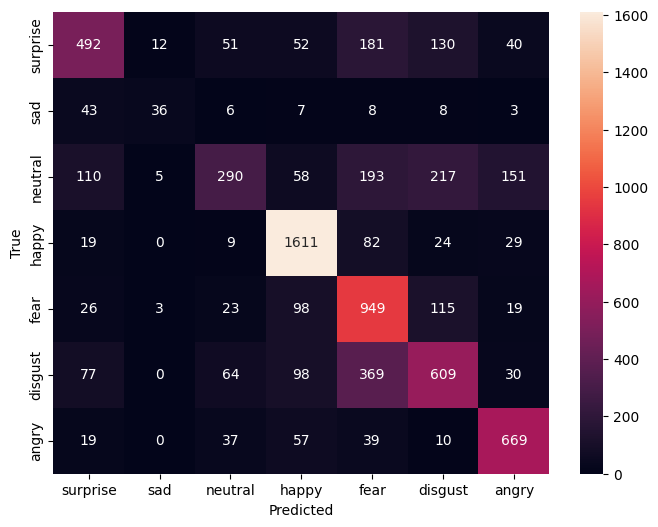

In [31]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
